# Logistic Regression (Olive Oils dataset)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


In [2]:
# import local utility functions and classes
import sys
sys.path.append('../utils')
import utils as utl
from data import Data

## Load raw data and plot

In [3]:
# init data object
data_obj = Data('../../data/olive_oils/FTIR_olive_oils.csv', 'label', -3)
data = data_obj.data
data.head(5)

,798.892,800.8215,802.751,804.6805,806.61,808.5395,810.469,812.3985,814.328,816.2575,...,1885.2305,1887.16,1889.0895,1891.019,1892.9485,1894.878,1896.8085,code,label,sample
44,0.127147,0.127587,0.129321,0.131166,0.133155,0.135617,0.138395,0.140899,0.143519,0.145796,...,0.003791,0.003540,0.003430,0.003345,0.003275,0.003094,0.002959,2,Italy,23
47,0.126618,0.127110,0.128289,0.130156,0.132573,0.135221,0.137872,0.140590,0.142919,0.144947,...,0.006713,0.006519,0.006012,0.005937,0.005862,0.005570,0.005606,2,Italy,24
4,0.128602,0.128790,0.130022,0.132012,0.134427,0.137070,0.139646,0.142338,0.144923,0.146958,...,0.010594,0.010379,0.010287,0.010127,0.009966,0.009760,0.009649,1,Greece,3
55,0.128149,0.128600,0.130136,0.132407,0.135488,0.138501,0.141224,0.144109,0.146412,0.148171,...,0.010286,0.010086,0.009620,0.009541,0.009713,0.009405,0.009267,3,Portugal,28
26,0.128867,0.129291,0.130672,0.132708,0.135109,0.137758,0.140860,0.143611,0.145792,0.147613,...,0.007027,0.006848,0.006511,0.006470,0.006405,0.006071,0.005872,2,Italy,14


Greece: blue
Italy: red
Portugal: green
Spain: orange


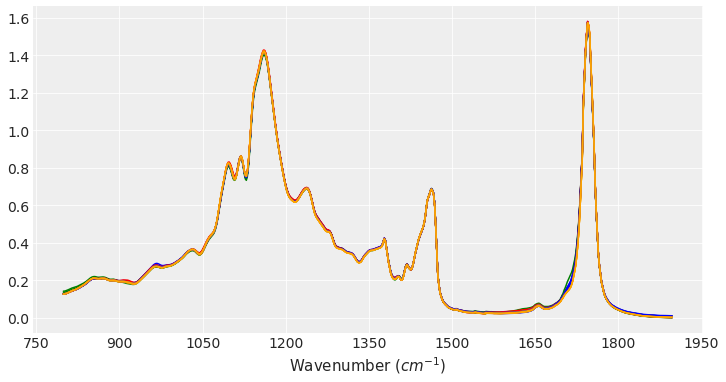

In [4]:
# name of column containing the labels
label_col = data_obj.label_column

# number of non-data columns at right of dataframe
non_data_cols = data_obj.non_data_columns

# list of class labels
class_labels = data_obj.get_class_labels()

# plot dataframe
utl.plot_data(data_obj, 20)

In [5]:
# number of samples from each class
data[label_col].value_counts()

Spain       50
Italy       34
Greece      20
Portugal    16
Name: label, dtype: int64

In [6]:
# generate training and test sets
train_data, test_data = train_test_split(data, test_size=0.33, random_state=42)

# rename the index
test_data.index = range(len(test_data))
train_data.index = range(len(train_data))

In [7]:
test_data.shape

(40, 573)

In [8]:
train_data.shape

(80, 573)

# Model definition (Multiple Logistic Regression)
The following statistical model is assumed:

\begin{equation}
\alpha \sim \mathcal{N}(\mu_{\alpha},\,\sigma^{2}_{\alpha}) \\
\beta \sim \mathcal{N}(\mu_{\beta},\,\sigma^{2}_{\beta}) \\
\theta = softmax(\alpha+\beta X) \\
y \sim Categorical(\theta)
\end{equation}

In [9]:
# get Y labels and standardize data
Y = pd.Categorical(train_data[label_col]).codes
x_n = train_data.columns[:non_data_cols]
x_s = train_data[x_n].values
x_s = utl.standardize(x_s)

In [10]:
train_data[label_col].value_counts()

Spain       33
Italy       22
Greece      14
Portugal    11
Name: label, dtype: int64

In [11]:
import theano.tensor as tt

with pm.Model() as model_mlr: 
    alpha = pm.Normal('alpha', mu=0, sd=1, shape=len(class_labels))
    beta = pm.Normal('beta', mu=0, sd=1, shape=(len(x_n), len(class_labels)))
                     
    mu = pm.Deterministic('mu', alpha + pm.math.dot(x_s, beta))
                     
    theta = tt.nnet.softmax(mu)
                     
    y_pred = pm.Categorical('y_pred', p=theta, observed=Y)
                     
    trace_mlr = pm.sample(1000, init='adapt_diag', random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [17:19<00:00,  2.89draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


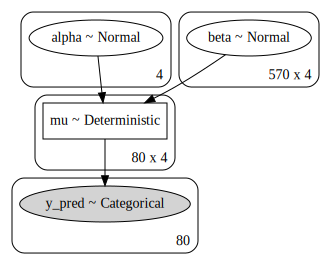

In [12]:
pm.model_to_graphviz(model_mlr)

# Model evaluation

In [13]:
varnames = ['alpha', 'beta']
coef = az.summary(trace_mlr, varnames)
coef

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.271,0.483,-1.231,0.632,0.051,0.036,90.0,90.0,90.0,156.0,1.01
alpha[1],0.194,0.482,-0.789,1.071,0.051,0.036,91.0,91.0,91.0,157.0,1.01
alpha[2],-0.522,0.485,-1.501,0.376,0.051,0.036,90.0,90.0,90.0,154.0,1.01
alpha[3],0.606,0.483,-0.390,1.469,0.051,0.036,90.0,90.0,91.0,156.0,1.01
"beta[0,0]",0.044,0.981,-1.995,1.732,0.040,0.028,607.0,607.0,609.0,861.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
"beta[568,3]",0.049,1.009,-1.733,1.981,0.042,0.030,585.0,585.0,586.0,937.0,1.00
"beta[569,0]",0.066,1.002,-1.818,1.926,0.039,0.027,671.0,671.0,675.0,938.0,1.00
"beta[569,1]",-0.075,0.986,-1.899,1.777,0.043,0.031,517.0,517.0,517.0,864.0,1.00
"beta[569,2]",0.050,0.978,-1.840,1.815,0.043,0.030,525.0,525.0,528.0,1035.0,1.01


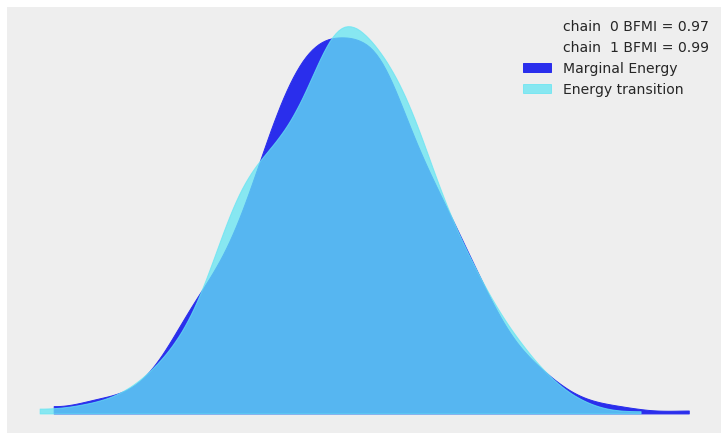

In [14]:
#az.plot_forest(trace_mlr, var_names=varnames, combined=True);
az.plot_energy(trace_mlr, figsize=(10, 6));

In [15]:
# correct predictions on training data
utl.softmax_score(data_obj, train_data, trace_mlr)

total  : 80
correct: 33
error  : 47
score  : 41.2%


# Save inference results

In [16]:
pm.backends.text.dump('./traces/trace_olive_oils', trace_mlr)